In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import tqdm
import re

import torch 

import sklearn
import sklearn.covariance
from sklearn import svm

import matplotlib.pyplot as plt

from icd9cms.icd9 import search

with open("./data/pcode_dict.txt", "rb") as fp: 
    icd9_pcode_dict = pickle.load(fp)
    
from transformers import AutoTokenizer
NTDBGPT2_tokenizer = AutoTokenizer.from_pretrained('dracoglacius/NTDB-GPT2')

/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview

We have the intuition that given a distribution with center of the hyper-elliposid $c$ and the shape of the ellipsoid defined by $\Sigma$, $c$ and $\sigma$ should not deviate from the empirical mean ($\hat{c}$) and the covariance estimations ($\hat{\Sigma}$) taken from the training data. 

To obtain these estimates we need to:

1. Feed the NTDB model with the training data (length $n$) and from the last token get the features of each layer ($n$ x 13 x 768)
1. Calculate the sample mean ($\hat{c}$) and the covariance estimate ($\hat{\Sigma}$), while also getting the estimated pseudo-inverse (called `.precision_` in sklearn)

To obtain the OOD estimation we need to:

1. Calculate the Mahalanobis Distance Feature (MDF) using the generated data (should be a vector equal to the number of layers)
1. Calculate the Anomaly Score
  1. This is a one-class SVM with a linear kernel with MDF as features

## Helper Functions

In [2]:
def metric(dir_name, stypes = ['Bas', 'Gau'], verbose=False):
    tp, fp, tnr_at_tpr95 = get_curve(dir_name, stypes)
    results = dict()
    mtypes = ['TNR', 'AUROC', 'DTACC', 'AUIN', 'AUOUT']
    if verbose:
        print('      ', end='')
        for mtype in mtypes:
            print(' {mtype:6s}'.format(mtype=mtype), end='')
        print('')
        
    for stype in stypes:
        if verbose:
            print('{stype:5s} '.format(stype=stype), end='')
        results[stype] = dict()
        
        # TNR
        mtype = 'TNR'
        results[stype][mtype] = tnr_at_tpr95[stype]
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUROC
        mtype = 'AUROC'
        tpr = np.concatenate([[1.], tp[stype]/tp[stype][0], [0.]])
        fpr = np.concatenate([[1.], fp[stype]/fp[stype][0], [0.]])
        results[stype][mtype] = -np.trapz(1.-fpr, tpr)
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # DTACC
        mtype = 'DTACC'
        results[stype][mtype] = .5 * (tp[stype]/tp[stype][0] + 1.-fp[stype]/fp[stype][0]).max()
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUIN
        mtype = 'AUIN'
        denom = tp[stype]+fp[stype]
        denom[denom == 0.] = -1.
        pin_ind = np.concatenate([[True], denom > 0., [True]])
        pin = np.concatenate([[.5], tp[stype]/denom, [0.]])
        results[stype][mtype] = -np.trapz(pin[pin_ind], tpr[pin_ind])
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
        
        # AUOUT
        mtype = 'AUOUT'
        denom = tp[stype][0]-tp[stype]+fp[stype][0]-fp[stype]
        denom[denom == 0.] = -1.
        pout_ind = np.concatenate([[True], denom > 0., [True]])
        pout = np.concatenate([[0.], (fp[stype][0]-fp[stype])/denom, [.5]])
        results[stype][mtype] = np.trapz(pout[pout_ind], 1.-fpr[pout_ind])
        if verbose:
            print(' {val:6.3f}'.format(val=100.*results[stype][mtype]), end='')
            print('')
    return results

In [3]:
def get_curve(dir_name, stypes = ['Baseline', 'Gaussian_LDA']):
    tp, fp = dict(), dict()
    tnr_at_tpr95 = dict()
    for stype in stypes:
        known = np.loadtxt('{}/confidence_{}_In.txt'.format(dir_name, stype), delimiter='\n')
        novel = np.loadtxt('{}/confidence_{}_Out.txt'.format(dir_name, stype), delimiter='\n')
        known.sort()
        novel.sort()
        end = np.max([np.max(known), np.max(novel)])
        start = np.min([np.min(known),np.min(novel)])
        num_k = known.shape[0]
        num_n = novel.shape[0]
        tp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        fp[stype] = -np.ones([num_k+num_n+1], dtype=int)
        tp[stype][0], fp[stype][0] = num_k, num_n
        k, n = 0, 0
        for l in range(num_k+num_n):
            if k == num_k:
                tp[stype][l+1:] = tp[stype][l]
                fp[stype][l+1:] = np.arange(fp[stype][l]-1, -1, -1)
                break
            elif n == num_n:
                tp[stype][l+1:] = np.arange(tp[stype][l]-1, -1, -1)
                fp[stype][l+1:] = fp[stype][l]
                break
            else:
                if novel[n] < known[k]:
                    n += 1
                    tp[stype][l+1] = tp[stype][l]
                    fp[stype][l+1] = fp[stype][l] - 1
                else:
                    k += 1
                    tp[stype][l+1] = tp[stype][l] - 1
                    fp[stype][l+1] = fp[stype][l]
        tpr95_pos = np.abs(tp[stype] / num_k - .95).argmin()
        tnr_at_tpr95[stype] = 1. - fp[stype][tpr95_pos] / num_n
    return tp, fp, tnr_at_tpr95

In [4]:
def detection_performance(scores, Y, outf, tag='TMP'):
    """
    Measure the detection performance
    return: detection metrics
    """
    os.makedirs(outf, exist_ok=True)
    num_samples = scores.shape[0]
    l1 = open('%s/confidence_%s_In.txt'%(outf, tag), 'w')
    l2 = open('%s/confidence_%s_Out.txt'%(outf, tag), 'w')
    y_pred = scores # regressor.predict_proba(X)[:, 1]

    for i in range(num_samples):
        if Y[i] == 0:
            l1.write("{}\n".format(-y_pred[i]))
        else:
            l2.write("{}\n".format(-y_pred[i]))
    l1.close()
    l2.close()
    results = metric(outf, [tag])
    return results

## MDF Functions

In [5]:
def get_empirical_mean_cov(cov_estimator, layer_embeddings, num_layers=13):
    mean_list = []
    precision_list = []

    for l in tqdm.tqdm(range(num_layers)):
        sample_mean = torch.mean(layer_embeddings[:,l,:], axis=0)
        X = layer_embeddings[:,l,:] - sample_mean
        cov_estimator.fit(X.numpy())
        temp_precision = cov_estimator.precision_
        temp_precision = torch.from_numpy(temp_precision).float()
        mean_list.append(sample_mean)#.to(device))
        precision_list.append(temp_precision)#.to(device))
    return mean_list, precision_list

In [6]:
def get_mdf(test_layer_embeddings, layer_mean, layer_precision, num_layers=13):
    mdf_list = []
    
    for l in tqdm.tqdm(range(num_layers)):
        zero_f = test_layer_embeddings[:,l,:] - layer_mean[l]
        gaussian_score = -0.5 * ((zero_f @ layer_precision[l]) @ zero_f.t()).diag()
        mdf_list.append(gaussian_score)
    
    return torch.stack(mdf_list).transpose(1,0)

In [7]:
def get_score(trn_mdf, test_mdf, ood_mdf, label):
    
    candidate_list = [1e-15, 1e-12, 1e-9, 1e-7, 1e-5, 1e-3, 0.01, 0.1, 0.2, 0.5, 1]

    ood_labels = np.ones(shape=(ood_mdf.shape[0], ))
    test_labels = np.zeros(shape=(test_mdf.shape[0], ))

    np.random.shuffle(test_mdf)
    np.random.shuffle(ood_mdf)
    best_ours_results = None
    best_ours_AUROC = 0.0
    best_model = None
    # for k in ['poly', 'linear']:
    for k in ['linear']:
        for nuu in tqdm.tqdm(candidate_list):
            print ("running ---:", "kernel:", k, "nuu:", nuu)
            
            c_lr = svm.OneClassSVM(nu=nuu, kernel=k, degree=2, tol=1e-5)
            #c_lr = sklearn.linear_model.SGDOneClassSVM(nu=nuu, random_state=42)
            c_lr.fit(trn_mdf)
            
            test_scores = c_lr.score_samples(test_mdf)
            ood_scores = c_lr.score_samples(ood_mdf)
            X_scores = np.concatenate((ood_scores, test_scores))
            Y_test = np.concatenate((ood_labels, test_labels))

            results = detection_performance(X_scores, Y_test, 'mah_logs', tag='TMP')
            neg_resuls = detection_performance(-X_scores, Y_test, 'feats_logs', tag='TMP')
            if sum(results["TMP"].values()) < sum(neg_resuls["TMP"].values()):
                results = neg_resuls

            if results['TMP']['AUROC'] > best_ours_AUROC:
                best_ours_AUROC = results['TMP']['AUROC']
                best_ours_results = results
                best_hypers = '{}-{}'.format(k, nuu)
                # save data for plotting
                best_model = c_lr
                d = {"X_scores": X_scores, "Y_test": Y_test, "Features": np.concatenate((test_scores, ood_scores))}
    mtypes = ['AUROC', 'DTACC', 'AUIN', 'AUOUT']
    for mtype in mtypes:
        print(' {mtype:6s}'.format(mtype=mtype), end='')
    print('\n{val:6.2f}'.format(val=100.*best_ours_results['TMP']['AUROC']), end='')
    print(' {val:6.2f}'.format(val=100.*best_ours_results['TMP']['DTACC']), end='')
    print(' {val:6.2f}'.format(val=100.*best_ours_results['TMP']['AUIN']), end='')
    print(' {val:6.2f}\n'.format(val=100.*best_ours_results['TMP']['AUOUT']), end='')
    print("best hyper %s"%(best_hypers)) 
    print ("saving data for plotting")
    with open("./outputs/{}_{}.pkl".format('NTDB', label), "wb") as f:
        pickle.dump(d, f)
    print('-------------------------------')
    
    return d, best_model

In [8]:
def plot_scores(score_df, ft='X_scores'):
    plt.hist(score_df[score_df['Y_test']==1][ft], 100, alpha=0.7, label='Out of Distribution')
    plt.hist(score_df[score_df['Y_test']==0][ft], 100, alpha=0.7, label='In-Distribution')
    plt.legend(loc='upper right')
    plt.show()

In [9]:
def print_seq_dsc(seq):
    cds = seq.split()
    tp = 'START'
    for c in cds:
        if c == '<START>':
            print('=' * 9 + ' START ' + '=' * 9)
        elif c == '<DSTART>':
            tp = 'DX'
            print('=' * 10 + ' DXS ' + '=' * 10)
        elif c == '<PSTART>':
            tp = 'PR'
            print('=' * 10 + ' PRS ' + '=' * 10)
        elif c == '<END>':
            print('=' * 10 + ' END ' + '=' * 10)
        elif c == '<UNK>':
            print(f'{c}:Unknown Code')
        else:
            if tp == 'DX':
                d = search(c)
                if d:
                    print(d)
            if tp == 'PR':
                pr_cd = re.sub(r'\.', '', c)
                if pr_cd in icd9_pcode_dict:
                    print(f"{pr_cd}:{icd9_pcode_dict[pr_cd]}")
                else:
                    print(f'{pr_cd}:Unknown Code')

# Configurations

In [10]:
PRINT_SEQUENCES = 20
TRN_FRAC = 0.9

## Load Data

1. Get the training data specifically for E812.0, E965.4, and E924.0 (In-Domain)
1. Get the adversarial data

In [11]:
def filter_token_length(sequences, tok_len=19):
    filtered_sequences = []
    for seq in sequences:
        seq_ids = NTDBGPT2_tokenizer.encode(seq, return_tensors='pt')
        if len(seq_ids[0]) < 20:
            filtered_sequences.append(seq)
    return filtered_sequences

In [12]:
trn_seq = np.load("./data/25k_train_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")

e8120_trn_seq = filter_token_length([x for x in trn_seq if 'E812.0' in x]) # 5000 items
e9654_trn_seq = filter_token_length([x for x in trn_seq if 'E965.4' in x]) # 5000 items
e9240_trn_seq = filter_token_length([x for x in trn_seq if 'E924.0' in x]) # 5000 items

In [13]:
e8120_e9654_adv_seq = np.load("./outputs/e8120_e9654_adv_seq.npy", allow_pickle=True)
e8120_e9240_adv_seq = np.load("./outputs/e8120_e9240_adv_seq.npy", allow_pickle=True)
e9654_e8120_adv_seq = np.load("./outputs/e9654_e8120_adv_seq.npy", allow_pickle=True)
e9654_e9240_adv_seq = np.load("./outputs/e9654_e9240_adv_seq.npy", allow_pickle=True)
e9240_e8120_adv_seq = np.load("./outputs/e9240_e8120_adv_seq.npy", allow_pickle=True)
e9240_e9654_adv_seq = np.load("./outputs/e9240_e9654_adv_seq.npy", allow_pickle=True)

# E812.0 Commmon Data

In [15]:
e8120_trn_all_token_layer_embeddings = np.load("./outputs/e8120_trn_all_em.npy", allow_pickle=True)
e8120_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e8120_trn_all_token_layer_embeddings])

e8120_trn_end_token_layer_embeddings = e8120_trn_end_token_layer_embeddings[:int(len(e8120_trn_end_token_layer_embeddings)*TRN_FRAC),:,:]
e8120_tst_end_token_layer_embeddings = e8120_trn_end_token_layer_embeddings[int(len(e8120_trn_end_token_layer_embeddings)*TRN_FRAC):,:,:]

cov_estimator1 = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov = get_empirical_mean_cov(cov_estimator1, e8120_trn_end_token_layer_embeddings)
e8120_trn_mdf = get_mdf(torch.Tensor(e8120_trn_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)
e8120_tst_mdf = get_mdf(torch.Tensor(e8120_tst_end_token_layer_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|█████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1024.87it/s]


# E812.0 E965.4 Adversarial

In [16]:
e8120_e9654_adv_all_embeddings = np.load("./outputs/e8120_e9654_adv_all_em.npy", allow_pickle=True)
e8120_e9654_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e8120_e9654_adv_all_embeddings])

In [18]:
e8120_e9654_ood_mdf = get_mdf(torch.Tensor(e8120_e9654_adv_end_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 21.02it/s]


In [19]:
e8120_e9654_score, e8120_e9654_det = get_score(e8120_trn_mdf, e8120_tst_mdf, e8120_e9654_ood_mdf, 'E8120_E9654_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 36%|███████████████████████▎                                        | 4/11 [00:00<00:00, 31.17it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001
running ---: kernel: linear nuu: 0.01


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 23.46it/s]

running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2
running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.39it/s]

 AUROC  DTACC  AUIN   AUOUT 
 80.52  76.66  18.79  97.97
best hyper linear-0.5
saving data for plotting
-------------------------------


In [20]:
e8120_e9654_score_df = pd.DataFrame(e8120_e9654_score)

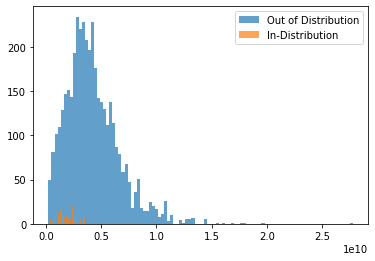

In [21]:
plot_scores(e8120_e9654_score_df)

In [22]:
y1 = e8120_e9654_det.score_samples(e8120_e9654_ood_mdf)

In [33]:
split1 = 0.5e10

In [34]:
e8120_e9654_normal = []
for i,o in enumerate(y1):
    if o < split1:
        e8120_e9654_normal.append((i,o))

In [35]:
e8120_e9654_anomaly = []
for i,o in enumerate(y1):
    if o >= split1:
        e8120_e9654_anomaly.append((i,o))

In [36]:
print('Normal:', len(e8120_e9654_normal), 'Anomaly:', len(e8120_e9654_anomaly))

Normal: 2813 Anomaly: 1201


In [37]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e8120_e9654_adv_seq[e8120_e9654_normal[i][0]]:
        print(format(e8120_e9654_normal[i][1], '.1e'))
        print(print_seq_dsc(e8120_e9654_adv_seq[e8120_e9654_normal[i][0]]))

1.2e+09
========= START =========
========== DXS ==========
8600:Traum pneumothorax-close:Traumatic pneumothorax without mention of open wound into thorax
80702:Fracture two ribs-closed:Closed fracture of two ribs
========== PRS ==========
========== END ==========
None
1.2e+09
========= START =========
========== DXS ==========
9190:Abrasion NEC:Abrasion or friction burn of other, multiple, and unspecified sites, without mention of infection
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
8509:Concussion NOS:Concussion, unspecified
82525:Fx metatarsal-closed:Closed fracture of metatarsal bone(s)
========== PRS ==========
3404:Insertion of intercostal catheter for drainage
3893:Venous catheterization, not elsewhere classified
3893:Venous catheterization, not elsewhere classified
9904:Transfusion of packed cells
5794:Insertion of indwelling urinary catheter
5794:Insertion of indwelling urinary catheter
9357:Application of other w

In [38]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e8120_e9654_adv_seq[e8120_e9654_anomaly[i][0]]:
        print(format(e8120_e9654_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e8120_e9654_adv_seq[e8120_e9654_anomaly[i][0]]))

7.2e+09
========= START =========
========== DXS ==========
92411:Contusion of knee:Contusion of knee
8245:Fx bimalleolar-open:Bimalleolar fracture, open
========== PRS ==========
8703:Computerized axial tomography of head
996:Unknown Code
========== END ==========
None
7.2e+09
========= START =========
========== DXS ==========
82101:Fx femur shaft-closed:Closed fracture of shaft of femur
========== PRS ==========
3712:Pericardiotomy
3404:Insertion of intercostal catheter for drainage
3482:Suture of laceration of diaphragm
8809:Other soft tissue x-ray of abdominal wall
5061:Closure of laceration of liver
8822:Skeletal x-ray of elbow and forearm
8823:Skeletal x-ray of wrist and hand
9918:Injection or infusion of electrolytes
8744:Routine chest x-ray, so described
7932:Open reduction of fracture with internal fixation, radius and ulna
7962:Debridement of open fracture site, radius and ulna
========== END ==========
None
6.0e+09
========= START =========
========== DXS ==========
9110:Ab

# E812.0 E924.0 Adversarial

In [39]:
e8120_e9240_adv_all_embeddings = np.load("./outputs/e8120_e9240_adv_all_em.npy", allow_pickle=True)
e8120_e9240_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e8120_e9240_adv_all_embeddings])

In [40]:
e8120_e9240_ood_mdf = get_mdf(torch.Tensor(e8120_e9240_adv_end_embeddings), e8120_trn_end_token_mean, e8120_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.42it/s]


In [41]:
e8120_e9240_score, e8120_e9240_det = get_score(e8120_trn_mdf, e8120_tst_mdf, e8120_e9240_ood_mdf, 'E8120_E9240_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 23.14it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 25.78it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 14.24it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.60it/s]

 AUROC  DTACC  AUIN   AUOUT 
 70.86  70.23  11.38  97.17
best hyper linear-1e-15
saving data for plotting
-------------------------------


In [42]:
e8120_e9240_score_df = pd.DataFrame(e8120_e9240_score)

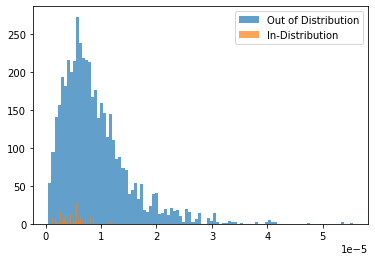

In [43]:
plot_scores(e8120_e9240_score_df)

In [44]:
y2 = e8120_e9240_det.score_samples(e8120_e9240_ood_mdf)

In [45]:
split2 = 1e-5

In [46]:
e8120_e9240_normal = []
for i,o in enumerate(y2):
    if o < split2:
        e8120_e9240_normal.append((i,o))

In [47]:
e8120_e9240_anomaly = []
for i,o in enumerate(y2):
    if o >= split2:
        e8120_e9240_anomaly.append((i,o))

In [48]:
print('Normal:', len(e8120_e9240_normal), 'Anomaly:', len(e8120_e9240_anomaly))

Normal: 3147 Anomaly: 1540


In [49]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e8120_e9240_adv_seq[e8120_e9240_normal[i][0]]:
        print(format(e8120_e9240_normal[i][1], '.1e'))
        print(print_seq_dsc(e8120_e9240_adv_seq[e8120_e9240_normal[i][0]]))

9.1e-06
========= START =========
========== DXS ==========
8600:Traum pneumothorax-close:Traumatic pneumothorax without mention of open wound into thorax
80702:Fracture two ribs-closed:Closed fracture of two ribs
========== PRS ==========
3893:Venous catheterization, not elsewhere classified
8628:Nonexcisional debridement of wound, infection or burn
9357:Application of other wound dressing
9333:Other hydrotherapy
========== END ==========
None
9.1e-06
========= START =========
========== DXS ==========
9190:Abrasion NEC:Abrasion or friction burn of other, multiple, and unspecified sites, without mention of infection
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
8509:Concussion NOS:Concussion, unspecified
82525:Fx metatarsal-closed:Closed fracture of metatarsal bone(s)
========== PRS ==========
9357:Application of other wound dressing
9357:Application of other wound dressing
8669:Other skin graft to other sites
864:Radical exc

In [50]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e8120_e9240_adv_seq[e8120_e9240_anomaly[i][0]]:
        print(format(e8120_e9240_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e8120_e9240_adv_seq[e8120_e9240_anomaly[i][0]]))

1.6e-05
========= START =========
========== DXS ==========
79311:Solitary pulmonry nodule:Solitary pulmonary nodule
83304:Disloc carpometacarp-cl:Closed dislocation of carpometacarpal (joint)
7856:Enlargement lymph nodes:Enlargement of lymph nodes
784:Symptoms involving head and neck:None
7339:Other and unspecified disorders of bone and cartilage:None
733:Other disorders of bone and cartilage:None
721:Spondylosis and allied disorders:None
428:Heart failure:None
42769:Premature beats NEC:Other premature beats
4263:Left bb block NEC:Other left bundle branch block
4148:Chr ischemic hrt dis NEC:Other specified forms of chronic ischemic heart disease
414:Other forms of chronic ischemic heart disease:None
412:Old myocardial infarction:None
4019:Hypertension NOS:Unspecified essential hypertension
2989:Psychosis NOS:Unspecified psychosis
2886:Elevated white blood cell count:None
2724:Hyperlipidemia NEC/NOS:Other and unspecified hyperlipidemia
2449:Hypothyroidism NOS:Unspecified acquired hypot

# E965.4 Common Data

In [51]:
e9654_trn_all_token_layer_embeddings = np.load("./outputs/e9654_trn_all_em.npy", allow_pickle=True)
e9654_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9654_trn_all_token_layer_embeddings])

e9654_trn_end_token_layer_embeddings = e9654_trn_end_token_layer_embeddings[:int(len(e9654_trn_end_token_layer_embeddings)*TRN_FRAC),:,:]
e9654_tst_end_token_layer_embeddings = e9654_trn_end_token_layer_embeddings[int(len(e9654_trn_end_token_layer_embeddings)*TRN_FRAC):,:,:]

cov_estimator2 = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov = get_empirical_mean_cov(cov_estimator2, e9654_trn_end_token_layer_embeddings)
e9654_trn_mdf = get_mdf(torch.Tensor(e9654_trn_end_token_layer_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)
e9654_tst_mdf = get_mdf(torch.Tensor(e9654_tst_end_token_layer_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)

100%|█████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1053.28it/s]


# E965.4 E812.0 Adversarial

In [52]:
e9654_e8120_adv_all_embeddings = np.load("./outputs/e9654_e8120_adv_all_em.npy", allow_pickle=True)
e9654_e8120_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e9654_e8120_adv_all_embeddings])

In [53]:
e9654_e8120_ood_mdf = get_mdf(torch.Tensor(e9654_e8120_adv_end_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 19.67it/s]


In [54]:
e9654_e8120_score, e9654_e8120_det = get_score(e9654_trn_mdf, e9654_tst_mdf, e9654_e8120_ood_mdf, 'E9654_E8120_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 29.11it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 64%|████████████████████████████████████████▋                       | 7/11 [00:00<00:00, 28.81it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2
running ---: kernel: linear nuu: 0.5


 91%|█████████████████████████████████████████████████████████▎     | 10/11 [00:00<00:00,  8.78it/s]

running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.54it/s]

 AUROC  DTACC  AUIN   AUOUT 
 74.13  70.91  15.77  97.13
best hyper linear-0.2
saving data for plotting
-------------------------------


In [55]:
e9654_e8120_score_df = pd.DataFrame(e9654_e8120_score)

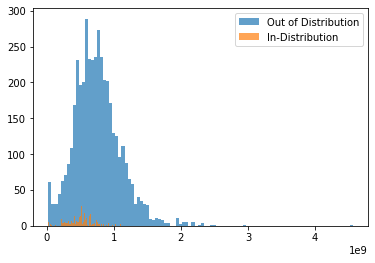

In [56]:
plot_scores(e9654_e8120_score_df)

In [57]:
y3 = e9654_e8120_det.score_samples(e9654_e8120_ood_mdf)

In [58]:
split3 = 1e9

In [59]:
e9654_e8120_normal = []
for i,o in enumerate(y3):
    if o < split3:
        e9654_e8120_normal.append((i,o))

In [60]:
e9654_e8120_anomaly = []
for i,o in enumerate(y3):
    if o >= split3:
        e9654_e8120_anomaly.append((i,o))

In [61]:
print('Normal:', len(e9654_e8120_normal), 'Anomaly:', len(e9654_e8120_anomaly))

Normal: 3438 Anomaly: 862


In [62]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9654_e8120_adv_seq[e9654_e8120_normal[i][0]]:
        print(format(e9654_e8120_normal[i][1], '.1e'))
        print(print_seq_dsc(e9654_e8120_adv_seq[e9654_e8120_normal[i][0]]))

7.6e+08
========= START =========
========== DXS ==========
8053:Fx dorsal vertebra-open:Open fracture of dorsal [thoracic] vertebra without mention of spinal cord injury
8760:Open wound of back:Open wound of back, without mention of complication
30560:Cocaine abuse-unspec:Cocaine abuse, unspecified
30570:Amphetamine abuse-unspec:Amphetamine or related acting sympathomimetic abuse, unspecified
3051:Tobacco use disorder:Tobacco use disorder
========== PRS ==========
9352:Application of neck support
8801:Computerized axial tomography of abdomen
8741:Computerized axial tomography of thorax
========== END ==========
None
7.6e+08
========= START =========
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib
========== PRS ==========
========== END ==========
None
7.6e+08
========= START =========

In [63]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9654_e8120_adv_seq[e9654_e8120_anomaly[i][0]]:
        print(format(e9654_e8120_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e9654_e8120_adv_seq[e9654_e8120_anomaly[i][0]]))

1.3e+09
========= START =========
========== DXS ==========
8900:Open wound of hip/thigh:Open wound of hip and thigh, without mention of complication
========== PRS ==========
7939:Open reduction of fracture with internal fixation, other specified bone
3829:Other diagnostic procedures on blood vessels
3888:Other surgical occlusion of vessels, lower limb arteries
8849:Arteriography of other specified sites
3999:Other operations on vessels
8314:Fasciotomy
========== END ==========
None
1.3e+09
========= START =========
========== DXS ==========
90441:Injury popliteal artery:Injury to popliteal artery
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
82391:Fx fibula NOS-open:Open fracture of unspecified part of fibula alone
========== PRS ==========
8828:Skeletal x-ray of ankle and foot
8828:Skeletal x-ray of ankle and foot
5794:Insertion of indwelling urinary catheter
8826:Other skeletal x-ray of pelvis and hip
8827:Skeletal x-ray o

# E965.4 E924.0 Adversarial

In [64]:
e9654_e9240_adv_all_embeddings = np.load("./outputs/e9654_e9240_adv_all_em.npy", allow_pickle=True)
e9654_e9240_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e9654_e9240_adv_all_embeddings])

In [65]:
e9654_e9240_ood_mdf = get_mdf(torch.Tensor(e9654_e9240_adv_end_embeddings), e9654_trn_end_token_mean, e9654_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.23it/s]


In [66]:
e9654_e9240_score, e9654_e9240_det = get_score(e9654_trn_mdf, e9654_tst_mdf, e9654_e9240_ood_mdf, 'E9654_E9240_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 25.46it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 26.20it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 13.43it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.85it/s]

 AUROC  DTACC  AUIN   AUOUT 
 67.97  70.30  10.04  96.92
best hyper linear-0.2
saving data for plotting
-------------------------------


In [67]:
e9654_e9240_score_df = pd.DataFrame(e9654_e9240_score)

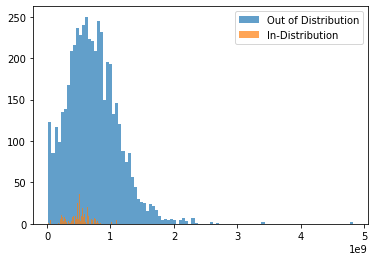

In [68]:
plot_scores(e9654_e9240_score_df)

In [69]:
y4 = e9654_e9240_det.score_samples(e9654_e9240_ood_mdf)

In [70]:
split4 = 1e9

In [71]:
e9654_e9240_normal = []
for i,o in enumerate(y4):
    if o < split4:
        e9654_e9240_normal.append((i,o))

In [72]:
e9654_e9240_anomaly = []
for i,o in enumerate(y4):
    if o >= split4:
        e9654_e9240_anomaly.append((i,o))

In [73]:
print('Normal:', len(e9654_e9240_normal), 'Anomaly:', len(e9654_e9240_anomaly))

Normal: 3785 Anomaly: 1099


In [74]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9654_e9240_adv_seq[e9654_e9240_normal[i][0]]:
        print(format(e9654_e9240_normal[i][1], '.1e'))
        print(print_seq_dsc(e9654_e9240_adv_seq[e9654_e9240_normal[i][0]]))

7.3e+08
========= START =========
========== DXS ==========
8053:Fx dorsal vertebra-open:Open fracture of dorsal [thoracic] vertebra without mention of spinal cord injury
8760:Open wound of back:Open wound of back, without mention of complication
30560:Cocaine abuse-unspec:Cocaine abuse, unspecified
30570:Amphetamine abuse-unspec:Amphetamine or related acting sympathomimetic abuse, unspecified
3051:Tobacco use disorder:Tobacco use disorder
========== PRS ==========
3893:Venous catheterization, not elsewhere classified
8628:Nonexcisional debridement of wound, infection or burn
9357:Application of other wound dressing
9333:Other hydrotherapy
========== END ==========
None
7.3e+08
========= START =========
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib
========== PRS ==========
9357:Appli

In [75]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9654_e9240_adv_seq[e9654_e9240_anomaly[i][0]]:
        print(format(e9654_e9240_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e9654_e9240_adv_seq[e9654_e9240_anomaly[i][0]]))

1.0e+09
========= START =========
========== DXS ==========
90253:Injury iliac artery:Injury to iliac artery
87343:Open wound of lip:Open wound of lip, without mention of complication
86819:Intra-abdom inj NEC-open:Injury to other and multiple intra-abdominal organs, with open wound into cavity
86339:Small intest inj NEC-opn:Other injury to small intestine, with open wound into cavity
82111:Fx femur shaft-open:Open fracture of shaft of femur
81231:Fx humerus shaft-open:Open fracture of shaft of humerus
========== PRS ==========
8628:Nonexcisional debridement of wound, infection or burn
3893:Venous catheterization, not elsewhere classified
========== END ==========
None
1.3e+09
========= START =========
========== DXS ==========
9593:Elb/forearm/wrst inj NOS:Elbow, forearm, and wrist injury
81513:Fx metacarpal shaft-open:Open fracture of shaft of metacarpal bone(s)
========== PRS ==========
8622:Excisional debridement of wound, infection, or burn
8628:Nonexcisional debridement of wound,

# E924.0 Common Data

In [76]:
e9240_trn_all_token_layer_embeddings = np.load("./outputs/e9240_trn_all_em.npy", allow_pickle=True)
e9240_trn_end_token_layer_embeddings = torch.stack([x[-1,:,:] for x in e9240_trn_all_token_layer_embeddings])

e9240_trn_end_token_layer_embeddings = e9240_trn_end_token_layer_embeddings[:int(len(e9240_trn_end_token_layer_embeddings)*TRN_FRAC),:,:]
e9240_tst_end_token_layer_embeddings = e9240_trn_end_token_layer_embeddings[int(len(e9240_trn_end_token_layer_embeddings)*TRN_FRAC):,:,:]

cov_estimator3 = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
e9240_trn_end_token_mean, e9240_trn_end_token_inv_cov = get_empirical_mean_cov(cov_estimator3, e9240_trn_end_token_layer_embeddings)
e9240_trn_mdf = get_mdf(torch.Tensor(e9240_trn_end_token_layer_embeddings), e9240_trn_end_token_mean, e9240_trn_end_token_inv_cov)
e9240_tst_mdf = get_mdf(torch.Tensor(e9240_tst_end_token_layer_embeddings), e9240_trn_end_token_mean, e9240_trn_end_token_inv_cov)

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 347.35it/s]


# E924.0 E812.0 Adversarial

In [77]:
e9240_e8120_adv_all_embeddings = np.load("./outputs/e9240_e8120_adv_all_em.npy", allow_pickle=True)
e9240_e8120_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e9240_e8120_adv_all_embeddings])

In [78]:
e9240_e8120_ood_mdf = get_mdf(torch.Tensor(e9240_e8120_adv_end_embeddings), e9240_trn_end_token_mean, e9240_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.12it/s]


In [79]:
e9240_e8120_score, e9240_e8120_det = get_score(e9240_trn_mdf, e9240_tst_mdf, e9240_e8120_ood_mdf, 'E9240_E8120_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 28.30it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 29.03it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 12.66it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.22it/s]

 AUROC  DTACC  AUIN   AUOUT 
 82.67  83.08  20.67  98.18
best hyper linear-0.5
saving data for plotting
-------------------------------


In [80]:
e9240_e8120_score_df = pd.DataFrame(e9240_e8120_score)

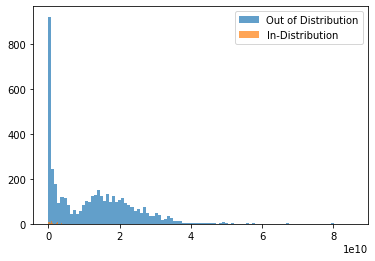

In [81]:
plot_scores(e9240_e8120_score_df)

In [82]:
y5 = e9240_e8120_det.score_samples(e9240_e8120_ood_mdf)

In [83]:
split5 = 0.1e10

In [84]:
e9240_e8120_normal = []
for i,o in enumerate(y5):
    if o < split5:
        e9240_e8120_normal.append((i,o))

In [85]:
e9240_e8120_anomaly = []
for i,o in enumerate(y5):
    if o >= split5:
        e9240_e8120_anomaly.append((i,o))

In [86]:
print('Normal:', len(e9240_e8120_normal), 'Anomaly:', len(e9240_e8120_anomaly))

Normal: 971 Anomaly: 3459


In [87]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9240_e8120_adv_seq[e9240_e8120_normal[i][0]]:
        print(format(e9240_e8120_normal[i][1], '.1e'))
        print(print_seq_dsc(e9240_e8120_adv_seq[e9240_e8120_normal[i][0]]))

2.2e+08
========= START =========
========== DXS ==========
9462:2nd deg burn mult site:Blisters, epidermal loss [second degree] of multiple specified sites
========== PRS ==========
7974:Closed reduction of dislocation of hand and finger
========== END ==========
None
2.2e+08
========= START =========
========== DXS ==========
948:Burns classified according to extent of body surface involved:None
9432:Blisters with epidermal loss due to burn (second degree) of upper limb except wrist and hand:None
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
94222:2nd deg burn chest wall:Blisters, epidermal loss [second degree] of chest wall, excluding breast and nipple
94127:2nd deg burn face NEC:Blisters, epidermal loss [second degree] of forehead and cheek
========== PRS ==========
7939:Open reduction of fracture with internal fixation, other specified bone
3829:Other diagnostic procedures on blood vessels
3888:Other surgical occlusion of vessels, lower limb a

In [88]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9240_e8120_adv_seq[e9240_e8120_anomaly[i][0]]:
        print(format(e9240_e8120_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e9240_e8120_adv_seq[e9240_e8120_anomaly[i][0]]))

1.3e+10
========= START =========
========== DXS ==========
94222:2nd deg burn chest wall:Blisters, epidermal loss [second degree] of chest wall, excluding breast and nipple
94223:2nd deg burn abdomn wall:Blisters, epidermal loss [second degree] of abdominal wall
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
94325:2nd deg burn shoulder:Blisters, epidermal loss [second degree] of shoulder
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94121:2nd deg burn ear:Blisters, epidermal loss [second degree] of ear [any part]
94127:2nd deg burn face NEC:Blisters, epidermal loss [second degree] of forehead and cheek
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified
========== PRS ==========
9352:Application of neck support
8801:Computerized axial tomography of abdomen
8741:Computerized axial tomography of thorax
========== END ==========


# E924.0 E965.4 Adversarial

In [89]:
e9240_e9654_adv_all_embeddings = np.load("./outputs/e9240_e9654_adv_all_em.npy", allow_pickle=True)
e9240_e9654_adv_end_embeddings = torch.stack([x[-1,:,:] for x in e9240_e9654_adv_all_embeddings])

In [90]:
e9240_e9654_ood_mdf = get_mdf(torch.Tensor(e9240_e9654_adv_end_embeddings), e9240_trn_end_token_mean, e9240_trn_end_token_inv_cov)

100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.16it/s]


In [91]:
e9240_e9654_score, e9240_e9654_det = get_score(e9240_trn_mdf, e9240_tst_mdf, e9240_e9654_ood_mdf, 'E9240_E9654_ADV')

/tmp/ipykernel_253398/963709382.py:8: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/tmp/ipykernel_253398/963709382.py:9: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)
 27%|█████████████████▍                                              | 3/11 [00:00<00:00, 26.84it/s]

running ---: kernel: linear nuu: 1e-15
running ---: kernel: linear nuu: 1e-12
running ---: kernel: linear nuu: 1e-09
running ---: kernel: linear nuu: 1e-07
running ---: kernel: linear nuu: 1e-05
running ---: kernel: linear nuu: 0.001


 55%|██████████████████████████████████▉                             | 6/11 [00:00<00:00, 27.45it/s]

running ---: kernel: linear nuu: 0.01
running ---: kernel: linear nuu: 0.1
running ---: kernel: linear nuu: 0.2


 82%|████████████████████████████████████████████████████▎           | 9/11 [00:00<00:00, 12.55it/s]

running ---: kernel: linear nuu: 0.5
running ---: kernel: linear nuu: 1


/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.12it/s]

 AUROC  DTACC  AUIN   AUOUT 
 86.24  85.64  24.78  98.59
best hyper linear-0.5
saving data for plotting
-------------------------------


In [92]:
e9240_e9654_score_df = pd.DataFrame(e9240_e9654_score)

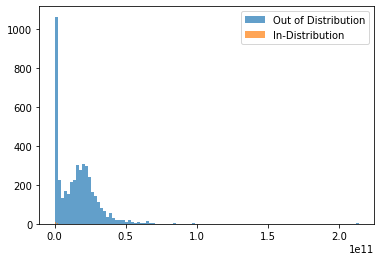

In [93]:
plot_scores(e9240_e9654_score_df)

In [94]:
y6 = e9240_e9654_det.score_samples(e9240_e9654_ood_mdf)

In [95]:
split6 = 1e9

In [96]:
e9240_e9654_normal = []
for i,o in enumerate(y6):
    if o < split6:
        e9240_e9654_normal.append((i,o))

In [97]:
e9240_e9654_anomaly = []
for i,o in enumerate(y6):
    if o >= split6:
        e9240_e9654_anomaly.append((i,o))

In [98]:
print('Normal:', len(e9240_e9654_normal), 'Anomaly:', len(e9240_e9654_anomaly))

Normal: 786 Anomaly: 3639


In [99]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9240_e9654_adv_seq[e9240_e9654_normal[i][0]]:
        print(format(e9240_e9654_normal[i][1], '.1e'))
        print(print_seq_dsc(e9240_e9654_adv_seq[e9240_e9654_normal[i][0]]))

1.8e+07
========= START =========
========== DXS ==========
9462:2nd deg burn mult site:Blisters, epidermal loss [second degree] of multiple specified sites
========== PRS ==========
========== END ==========
None
1.8e+07
========= START =========
========== DXS ==========
94800:Bdy brn < 10%/3d deg NOS:Burn [any degree] involving less than 10 percent of body surface with third degree burn, less than 10 percent or unspecified
94524:2nd deg burn lower leg:Blisters, epidermal loss [second degree] of lower leg
94522:2nd deg burn foot:Blisters, epidermal loss [second degree] of foot
========== PRS ==========
8741:Computerized axial tomography of thorax
9918:Injection or infusion of electrolytes
8838:Other computerized axial tomography
4461:Suture of laceration of stomach
4574:Open and other resection of transverse colon
5589:Other repair of kidney
7932:Open reduction of fracture with internal fixation, radius and ulna
7852:Internal fixation of bone without fracture reduction, humerus
7961:

In [100]:
for i in range(PRINT_SEQUENCES):
    if '<UNK>' not in e9240_e9654_adv_seq[e9240_e9654_anomaly[i][0]]:
        print(format(e9240_e9654_anomaly[i][1], '.1e'))
        print(print_seq_dsc(e9240_e9654_adv_seq[e9240_e9654_anomaly[i][0]]))

2.2e+09
========= START =========
========== DXS ==========
94222:2nd deg burn chest wall:Blisters, epidermal loss [second degree] of chest wall, excluding breast and nipple
94223:2nd deg burn abdomn wall:Blisters, epidermal loss [second degree] of abdominal wall
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
94325:2nd deg burn shoulder:Blisters, epidermal loss [second degree] of shoulder
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94121:2nd deg burn ear:Blisters, epidermal loss [second degree] of ear [any part]
94127:2nd deg burn face NEC:Blisters, epidermal loss [second degree] of forehead and cheek
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified
========== PRS ==========
========== END ==========
None
1.1e+10
========= START =========
========== DXS ==========
9492:2nd degree burn NOS:Blisters, epidermal loss [second d